<a href="https://colab.research.google.com/github/EleonoraBartolomucci/Fairness/blob/master/Simple_workflow_and_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from lxml import html
import pandas as pd
import json
import csv
import numpy as np
import itertools
import os
import pickle
import random
import datetime
import math
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import statistics as st
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

#!pip install balanced_kmeans
#from balanced_kmeans import kmeans
#from balanced_kmeans import kmeans_equal

import networkx as nx
import time

# CONSTANTS
business_headers = ['index', 'business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']

In [ ]:
# AUTHENTICATE IN GOOGLE DRIVE
def authenticate():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive
drive = authenticate()

In [ ]:
# PIPELINE
# DOWNLOAD restaurants.txt FROM DRIVE
restaurants_dataset_id = '1GMm3tvEkkNJnkNhNP9G3l6ibkUVG48nG'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': restaurants_dataset_id})
download.GetContentFile('risto2.txt')
with open('risto2.txt') as f:
    content = f.readlines()
restaurants_id_list = [x.strip() for x in content] 

print(restaurants_id_list)


download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
download.GetContentFile('gtree.csv')
gtree = pd.read_csv('gtree.csv')
#list_of_attributes = ['review_count'] # alluser
#list_of_attributes = ['review_count', 'fans', 'average_stars', 'useful', 'funny', 'cool'] # dataset
#list_of_attributes = ['loc1', 'loc2', 'loc3'] # dataset
#list_of_attributes = ['age', 'gender', 'ethnicity'] # alluser
#list_of_attributes = ['fans'] # dataset
#list_of_attributes = ['useful', 'funny', 'cool'] # dataset
#list_of_attributes = ['gender', 'ethnicity'] # alluser
#list_of_attributes = ['ethnicity'] # alluser
#list_of_attributes = ['review_count', 'friend_count', 'photo_count'] # alluser
#list_of_attributes = ['review_sentiment'] # alluser
list_of_attributes = ['gender'] # alluser
method = 'custom'
folder_name = '#14_custom_gender'
gtree_folder_destination_name = 'gfolder_#14'
N_of_groups = 3
alluser = True
#alluser = False

index_restaurant = 1
for id in restaurants_id_list[index_restaurant-1:index_restaurant]:

  authenticate()
  df_rel_ranking, df_date_ranking, df_rand_ranking = pipeline1(id, alluser)
  authenticate()

  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')
  
  destination = create_folder_in_drive(drive, folder_name, gtree.loc[gtree['business_id']==id, 'gfolder_groups'].tolist()[0])
  destination_copy = destination
  gtree.loc[gtree['business_id']==id, gtree_folder_destination_name] = destination
  gtree = drop_unnamed(gtree)
  gtree.to_csv('gtree.csv')
  upload_file('gtree.csv', '1eUt2wyCOULW0-LdL6vyRJi1mUs_U46DD') # id folder data

  group_list, percents, destination = pipeline2(df_rel_ranking, id,
                                   N_of_groups, list_of_attributes, method,
                                   alluser, destination, '')
  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  authenticate()
  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking,
            percents, list_of_attributes, alluser, destination, group_list)
  
  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')
  # ASSUMPTIONS
  # ALL MEN
  print('''#####################################################################
            ################## ASSUMPTION ALL MEN ###############################
            #####################################################################''')

  destination = destination_copy
  group_list, percents, destination = pipeline2(df_rel_ranking, id,
                                   N_of_groups, list_of_attributes, method,
                                   alluser, destination, 'all_men')
  
  print(percents)
  authenticate()
  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking,
            percents, list_of_attributes, alluser, destination, group_list)
  
  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  # ALL WOMEN
  print('''#####################################################################
            ################## ASSUMPTION ALL WOMEN #############################
            #####################################################################''')
  destination = destination_copy
  group_list, percents, destination = pipeline2(df_rel_ranking, id,
                                   N_of_groups, list_of_attributes, method,
                                   alluser, destination, 'all_women')
  print(group_list)
  print(percents)
  authenticate()

  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking,
            percents, list_of_attributes, alluser, destination, group_list)
  
  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  # 50%
  print('''#####################################################################
            ################## ASSUMPTION 50 AND 50 #############################
            #####################################################################''')
  destination = destination_copy
  group_list, percents, destination = pipeline2(df_rel_ranking, id,
                                   N_of_groups, list_of_attributes, method,
                                   alluser, destination, '50')
  print(group_list)
  print(percents)
  authenticate()

  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking, 
            percents, list_of_attributes, alluser, destination, group_list)

  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  # EQUALLY DISTRIBUTED
  print('''#####################################################################
            ################## ASSUMPTION EQUALLY DISTRIBUTED ###################
            #####################################################################''')
  destination = destination_copy
  group_list, percents, destination = pipeline2(df_rel_ranking, id,
                                   N_of_groups, list_of_attributes, method,
                                   alluser, destination, 'equal')
  print(group_list)
  print(percents)
  authenticate()

  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking,
            percents, list_of_attributes, alluser, destination, group_list)
  

  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  # MAINTAIN PROPORTION
  print('''#####################################################################
            ################## ASSUMPTION MAINTAIN PROPORTION ###################
            #####################################################################''')
  destination = destination_copy
  group_list, percents, destination = pipeline2(df_rel_ranking, id,
                                   N_of_groups, list_of_attributes, method,
                                   alluser, destination, 'proportioned')
  print(group_list)
  print(percents)
  authenticate()

  download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
  download.GetContentFile('gtree.csv')
  gtree = pd.read_csv('gtree.csv')

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking,
            percents, list_of_attributes, alluser, destination, group_list)

print('FIN')
  

Output streaming troncato alle ultime 5000 righe.
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
3

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


[37.056567593480345, 62.94343240651965, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       1.0
2082  5S6iNexQ44RaFIJC0rRinw       1.0
2083  5sJlO6HA_SzC_tn1rmKy4A       1.0
2084  sqq5uqXs5NLg_fOI7DtO9Q       1.0
2085  _qohdxiWQ0LO3ph_12BWaw       1.0

[2086 rows x 2 columns]
[37.056567593480345, 62.94343240651965, 0.0]
[37.056567593480345, 62.94343240651965, 0.0]

++++++++++++++++ EXPOSURE CALCULATION ++++++++++++++++++

----------------DEMOGRAPHIC PARITY EXP------------------

------------Ranking by Yelp filter:------------

all_exposures size: 773
all_exposures size: 1313
Group couples: [(0.0, 1.0)]
Size: 2086
Size: 2084
Size: 2082
  group_id  exposure
0        0  0.157504
1        1  0.155594


------------Ranking by Date:---

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:512: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[79.14669223394056, 20.853307766059444, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       0.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7DtO9Q       0.0
2085  _qohdxiWQ0LO3ph_12BWaw       0.0

[2086 rows x 2 columns]
[79.14669223394056, 20.853307766059444, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       0.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7DtO9

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


[49.95206136145733, 50.04793863854267, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       0.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7DtO9Q       0.0
2085  _qohdxiWQ0LO3ph_12BWaw       0.0

[2086 rows x 2 columns]
[49.95206136145733, 50.04793863854267, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       0.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7DtO9Q 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


[58.101629913710454, 41.898370086289546, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       1.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7DtO9Q       1.0
2085  _qohdxiWQ0LO3ph_12BWaw       0.0

[2086 rows x 2 columns]
[58.101629913710454, 41.898370086289546, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       1.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7Dt

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


[63.95014381591563, 36.04985618408437, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       0.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7DtO9Q       0.0
2085  _qohdxiWQ0LO3ph_12BWaw       0.0

[2086 rows x 2 columns]
[63.95014381591563, 36.04985618408437, 0.0]
                     user_id  group_id
0     PVyZXgOkVtnU6966FDFhuw       0.0
1     aK99XES2p7yNyWKpJjpxkQ       0.0
2     hVXj8lnaTIMLTkD_yjSj6A       0.0
3     wCDC5NVQLKdTa-OwzLG9vg       0.0
4     3VldYRmP6n2wIzaaRrWSNQ       1.0
...                      ...       ...
2081  JbiUKCxNdA71uJqTX3C2nQ       0.0
2082  5S6iNexQ44RaFIJC0rRinw       0.0
2083  5sJlO6HA_SzC_tn1rmKy4A       0.0
2084  sqq5uqXs5NLg_fOI7DtO9Q 

In [ ]:
def upload_file(filename, folder_id):
  drive = authenticate()
  fileList = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
  drive_file = drive.CreateFile({'title': filename, 'parents': [{'id': folder_id}]})
  # Check if file already exists in Google Drive (prevents duplicates)
  for file in fileList:
      if file['title'] == filename:  # The file already exists, then overwrite it
          fileID = file['id']
          drive_file = drive.CreateFile({'id': fileID, 'title': filename, 'parents': [{'id': folder_id}]})
  # Upload user picture on Google Drive
  drive_file.SetContentFile(filename)  # path of local file content
  drive_file.Upload()  # Upload the file.
  return drive_file['id']
  

def create_folder_in_drive(gdrive, folder_name, parent_folder_id):
  folder_metadata = {'title': folder_name,'mimeType': 'application/vnd.google-apps.folder',
                    'parents': [{"kind": "drive#fileLink", "id": parent_folder_id}]
                    }
  folder = gdrive.CreateFile(folder_metadata)
  folder.Upload()
  print(folder)
  # Return folder informations
  print('title: %s, id: %s' % (folder['title'], folder['id']))
  return folder['id']


# READ JSON
def read_json(json_path):
  data = []
  with open(json_path, "r") as my_file: 
    for line in my_file:
      line_json = json.loads(line)
      data.append(line_json)
  return data


# PARSE JSON IN CSV
def json2csv(csv_path, json_path):
  data = read_json(json_path)
  df = pd.DataFrame(data)
  df.to_csv(csv_path)


def drop_unnamed(df):
  cols = [c for c in df.columns if c.lower()[:7] != 'unnamed']
  return df[cols]


# JOIN USER FROM YELP WITH USER FROM DATASET AND PRINT LOST USERS
def filter_user_from_dataset(df, users):
  df = df[['position','user_id','date','location']] # Tolgo alcune colonne perché prendo quelle del dataset
  df_merged = df.merge(users, on='user_id')
  total_review = df['position'].max()
  print('Utenti persi: totali ' + str(total_review) + ' - utenti nel dataset ' +
        str(len(df_merged.index)) + ' = ' + str(total_review - len(df_merged.index)))
  df_merged['position'] = df_merged.index + 1
  df_merged = drop_unnamed(df_merged)
  return df_merged


def compute_groups_percents(df_groups, N_of_groups):
  total = len(df_groups.index)
  percents = []
  i = 0
  while i < N_of_groups:
    current_length = len(df_groups[df_groups['group_id'] == i].index)
    percents.append((current_length/total)*100)
    i = i + 1
  print(percents)
  return percents


# ADD REVIEW INFO IN RANKING DATAFRAME
def integrate_review_info(df, reviews, business_id):
  business_reviews = reviews[reviews['business_id'] == business_id]
  df_merged = business_reviews.merge(df, on='user_id')
  del df_merged['date_y']  # it's date from yelp website (not updated in dataset)
  df_merged = df_merged.rename(columns={'date_x':'date'})
  # drop duplicates reviews from same user
  df_merged = df_merged.sort_values('date').drop_duplicates('user_id',keep='last')
  df_merged = df_merged.sort_values(by=['position']).reset_index(drop=True)
  print('Review perse: ', len(df.index) - len(df_merged.index))
  df_merged['position'] = df_merged.index + 1
  df_merged = drop_unnamed(df_merged)
  df_merged = df_merged[['position', 'user_id', 'review_id', 'date', 'name', 'location', 'text', 'fans', 'average_stars', 'review_count', 'business_id']]
  
  return df_merged

import ast
def reorder_user_data(df):
  df['review_count'] = np.NaN
  df['friend_count'] = np.NaN
  df['location'] = np.NaN
  df['photo_count'] = np.NaN
  df['useful_votes'] = np.NaN
  df['funny_votes'] = np.NaN
  df['cool_votes'] = np.NaN
  df['text'] = ""
  for i, user in df.iterrows():
    print(i)
    user_data = user['user']
    user_data_converted = ast.literal_eval(user_data)
    df.loc[i, 'review_count'] = user_data_converted["reviewCount"]
    df.loc[i, 'friend_count'] = user_data_converted["friendCount"]
    df.loc[i, 'location'] = user_data_converted['displayLocation']
    df.loc[i, 'photo_count'] = user_data_converted['photoCount']
    comment_data = user['comment']
    comment_data_converted = ast.literal_eval(comment_data)
    df.loc[i, 'text'] = comment_data_converted["text"]
    feedback_data = user['feedback']
    feedback_data_converted = ast.literal_eval(feedback_data)
    counts_data = feedback_data_converted['counts']
    #counts_data_converted = ast.literal_eval(counts_data)
    df.loc[i, 'useful_votes'] = counts_data['useful']
    df.loc[i, 'funny_votes'] = counts_data['funny']
    df.loc[i, 'cool_votes'] = counts_data['cool']
  print('REORDER-----------------------------------------')
  print(df)
  df = drop_unnamed(df)
  return df



def generate_dummies(df, text_attribute_list):
  dummy_columns = []
  for attr in text_attribute_list:
    gender_dummies = pd.get_dummies(df[attr])
    dummy_columns = dummy_columns + list(gender_dummies.columns)
    df = pd.merge(df, gender_dummies, how="left",left_index=True, right_index=True)
    
    # drop all the unnamed columns
    df = drop_unnamed(df)
  return df, dummy_columns


def create_vectors_yelp(df_users, business_id, list_of_attributes, method, destination):
  vectors = df_users[['user_id', 'review_count', 'friend_count', 'location', 'photo_count']]
  # DEMOGRAPHICS
  vectors = get_demographics(vectors, business_id)
  # SENTIMENT
  #vectors = get_sentiment(vectors, business_id)

  print(vectors.columns)
  # UPLOAD VECTORS IN DRIVE
  vectors.to_csv('user_vectors_' + business_id + '.csv')
  upload_file('user_vectors_' + business_id + '.csv',destination)
  return vectors


def get_sentiment(vectors, id):
  df_sentiment = pd.read_csv('sentiment_' + id + '.csv')
  new_vectors = pd.merge(vectors, df_sentiment, on='user_id', how='left')
  new_vectors = drop_unnamed(new_vectors)
  return new_vectors


def get_demographics(vectors, id):
  demographics_file_id = gtree.loc[gtree['business_id']==id, 'gfolder_clarifai'].tolist()[0]
  download = drive.CreateFile({'id': demographics_file_id})
  download.GetContentFile('demographics_'  + id + '.csv')
  df_demographics = pd.read_csv('demographics_' + id + '.csv')
  df_demographics = df_demographics.sort_values(['user_id', 'age'], ascending=[True, False])
  df_demographics = df_demographics.drop_duplicates('user_id',keep='first').reset_index(drop=True)
  new_vectors = pd.merge(vectors, df_demographics, on='user_id', how='left')
  new_vectors = drop_unnamed(new_vectors)
  return new_vectors



def pipeline1(business_id, alluser):
  ### READ THE RANKING FROM GTREE
  local_ranking_folder = gtree.loc[gtree['business_id']==id, 'gfolder_rankings'].tolist()[0]
  print(local_ranking_folder)
  local_ranking_files = drive.ListFile({'q': "'" + local_ranking_folder + "' in parents and trashed=false"}).GetList()
  download = drive.CreateFile({'id': local_ranking_files[0]['id']})
  download.GetContentFile(local_ranking_files[0]['title'])
  print(local_ranking_files[0]['id'])
  df_date_ranking = pd.read_csv(local_ranking_files[0]['title'])

  download = drive.CreateFile({'id': local_ranking_files[1]['id']})
  download.GetContentFile(local_ranking_files[1]['title'])
  print(local_ranking_files[1]['id'])
  df_rand_ranking = pd.read_csv(local_ranking_files[1]['title'])

  download = drive.CreateFile({'id': local_ranking_files[2]['id']})
  download.GetContentFile(local_ranking_files[2]['title'])
  print(local_ranking_files[2]['id'])
  df_rel_ranking = pd.read_csv(local_ranking_files[2]['title'])
  
  print("Ranking by Yelp filter:")
  pd.set_option('display.max_columns', None)
  print(df_rel_ranking)
  print('\n')
  print("Ranking by Date:")
  print(df_date_ranking)
  print('\n')
  print("Ranking Random:")
  print(df_rand_ranking)
  print('\n')

  ###

  df_rel_ranking = reorder_user_data(df_rel_ranking)
  df_date_ranking = reorder_user_data(df_date_ranking)
  df_rand_ranking = reorder_user_data(df_rand_ranking)
    

  print("\n++++++++++++++++ RANKING ++++++++++++++++++\n")

  print("Ranking by Yelp filter:")
  pd.set_option('display.max_columns', None)
  print(df_rel_ranking)
  print('\n')
  print("Ranking by Date:")
  print(df_date_ranking)
  print('\n')
  print("Ranking Random:")
  print(df_rand_ranking)
  print('\n')

  return df_rel_ranking, df_date_ranking, df_rand_ranking


def pipeline2(df_ranking_by_relevance, id, N_of_groups,
              local_list_of_attributes, method, alluser, destination, assumption):
  print("\n++++++++++++++++ GROUPS CREATION ++++++++++++++++++\n")

  if alluser:
    df_vectors = create_vectors_yelp(df_ranking_by_relevance, id, local_list_of_attributes,
                                     method, destination)
    
  if method == 'custom':
    df_groups, destination = create_groups_custom(N_of_groups,local_list_of_attributes,id, destination, assumption)
  
  percents = compute_groups_percents(df_groups, N_of_groups)
  
  print(df_groups)
  print(percents)
  return df_groups, percents, destination


def pipeline3(business_id, method, df_ranking_by_relevance, df_ranking_by_date, 
              df_ranking_by_random, percents, list_of_attributes,
              alluser, destination, df_groups):
  
  df_result = pd.DataFrame(columns=['Exposure_method', 'Context', 'Means', 'P-value'])
  df_result.to_csv('result.csv')
  id_new_file = upload_file('result.csv', destination)


  print("\n++++++++++++++++ EXPOSURE CALCULATION ++++++++++++++++++\n")
  
  print("----------------DEMOGRAPHIC PARITY EXP------------------\n")
  print("------------Ranking by Yelp filter:------------\n")
  yelp_exposures, yelp_user_exposures = print_demographic_parity_exposure(business_id,
                                                    method, df_ranking_by_relevance,
                                                     "yelp_", list_of_attributes, destination)
  print("------------Ranking by Date:------------\n")
  date_exposures, date_user_exposures = print_demographic_parity_exposure(business_id,
                                                    method, df_ranking_by_date,
                                                     "date_", list_of_attributes, destination)
  print("------------Ranking Random:------------\n")
  random_exposures, rand_user_exposures = print_demographic_parity_exposure(business_id,
                                                      method, df_ranking_by_random,
                                                       "rand_", list_of_attributes, destination)
  
  array_group_id = np.arange(0,df_groups['group_id'].max()+1)
  filePath = stat_significance_inter_rankings(yelp_user_exposures, rand_user_exposures, method,
                                   "demgr_yelp_", business_id, array_group_id, destination) # group_id
  upload_file(filePath, destination)
  filePath = stat_significance_inter_rankings(date_user_exposures, rand_user_exposures, method,
                                   "demgr_date_", business_id, array_group_id, destination)
  upload_file(filePath, destination)

  if alluser and not set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    yelp_error = st.pstdev(yelp_user_exposures['exposure'])
    date_error = st.pstdev(date_user_exposures['exposure'])
    rand_error = st.pstdev(rand_user_exposures['exposure'])
  else:
    yelp_error = st.stdev(yelp_user_exposures['exposure'])
    date_error = st.stdev(date_user_exposures['exposure'])
    rand_error = st.stdev(rand_user_exposures['exposure'])
  
  get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_demgr_' + method + '_' + business_id, list_of_attributes,
            method, business_id, alluser, [yelp_error, date_error, rand_error], destination)
  get_scatter_plots(yelp_user_exposures, date_user_exposures, rand_user_exposures,
                    'scatter_demgr_' + method + '_' + business_id, list_of_attributes,
                    method, business_id, alluser, destination)
  

  print("----------------DISPARATE TREATMENT EXP------------------\n")
  print("------------Ranking by Yelp filter:------------\n")
  yelp_exposures, yelp_user_exposures = print_disparate_treatment_exposure(business_id,
                                                    method, df_ranking_by_relevance,
                                                     "yelp_", list_of_attributes, alluser, destination)
  print("------------Ranking by Date:------------\n")
  date_exposures, date_user_exposures = print_disparate_treatment_exposure(business_id,
                                                    method, df_ranking_by_date,
                                                     "date_", list_of_attributes, alluser, destination)
  print("------------Ranking Random:------------\n")
  random_exposures, rand_user_exposures = print_disparate_treatment_exposure(business_id,
                                                      method, df_ranking_by_random,
                                                       "rand_", list_of_attributes, alluser, destination)
  
  array_group_id = np.arange(0,df_groups['group_id'].max()+1)
  filePath = stat_significance_inter_rankings(yelp_user_exposures, rand_user_exposures, method,
                                   "disptr_yelp_", business_id, array_group_id, destination) # group_id
  upload_file(filePath, destination)
  filePath = stat_significance_inter_rankings(date_user_exposures, rand_user_exposures, method,
                                   "disptr_date_", business_id, array_group_id, destination)
  upload_file(filePath, destination)

  if alluser and not set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    yelp_error = st.pstdev(yelp_user_exposures['exposure'])
    date_error = st.pstdev(date_user_exposures['exposure'])
    rand_error = st.pstdev(rand_user_exposures['exposure'])
  else:
    yelp_error = st.stdev(yelp_user_exposures['exposure'])
    date_error = st.stdev(date_user_exposures['exposure'])
    rand_error = st.stdev(rand_user_exposures['exposure'])
  
  get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_disptr_' + method + '_' + business_id, list_of_attributes,
            method, business_id, alluser, [yelp_error, date_error, rand_error], destination)
  get_scatter_plots(yelp_user_exposures, date_user_exposures, rand_user_exposures,
                    'scatter_disptr_' + method + '_' + business_id, list_of_attributes,
                    method, business_id, alluser, destination)




  print("----------------DISPARATE IMPACT EXP------------------\n")
  print("------------Ranking by Yelp filter:------------\n")
  yelp_exposures, yelp_user_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_relevance,
                                                   "yelp_", list_of_attributes, alluser, destination)
  
  print("------------Ranking by Date:------------\n")
  date_exposures, date_user_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_date,
                                                   "date_", list_of_attributes, alluser, destination)
  
  print("------------Ranking Random:------------\n")
  random_exposures, rand_user_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_random,
                                                     "rand_", list_of_attributes, alluser, destination)
  
  filePath = stat_significance_inter_rankings(yelp_user_exposures, rand_user_exposures, method,
                                   "dispimp_yelp_", business_id, array_group_id, destination)
  upload_file(filePath, destination)
  filePath = stat_significance_inter_rankings(date_user_exposures, rand_user_exposures, method,
                                   "dispimp_date_", business_id, array_group_id, destination)
  upload_file(filePath, destination)

  if alluser and not set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    yelp_error = st.pstdev(yelp_user_exposures['exposure'])
    date_error = st.pstdev(date_user_exposures['exposure'])
    rand_error = st.pstdev(rand_user_exposures['exposure'])
  else:
    yelp_error = st.stdev(yelp_user_exposures['exposure'])
    date_error = st.stdev(date_user_exposures['exposure'])
    rand_error = st.stdev(rand_user_exposures['exposure'])
  
  get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_dispimp_' + method + '_' + business_id, list_of_attributes,
            method, business_id, alluser, [yelp_error, date_error, rand_error], destination)
  get_scatter_plots(yelp_user_exposures, date_user_exposures, rand_user_exposures,
                    'scatter_dispimp_' + method + '_' + business_id, list_of_attributes,
                    method, business_id, alluser, destination)


def create_groups_custom(N_of_groups, list_of_attributes, id, destination, assumption):
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")

  local_list_of_attributes = list_of_attributes

  if set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity', 'review_sentiment'])):
    text_attribute_list = ['gender', 'ethnicity']
    df_vectors, dummy_columns_name = generate_dummies(df_vectors, text_attribute_list)
    # list_of_attributes - text_attribute_list + dummy_columns_name
    # subtraction
    temp = [item for item in list_of_attributes if item not in text_attribute_list]
    list_of_attributes = temp + dummy_columns_name
    #serve per la descrizione dei gruppi, da fare

    #EXCLUDE USERS WITH NO INFO, CLUSTER THE REMAINING IN C-1
    df_no_info = df_vectors[df_vectors['age'] == -1.0]
    df_yes_info = df_vectors[df_vectors['age'] != -1.0]
    print('All users =', len(df_vectors))
    print('Users with info =',len(df_yes_info.index))
    print('User without info =',len(df_no_info.index))
  
  else:
    df_no_info = pd.DataFrame()
    df_yes_info = df_vectors

  
  # GRUPPI PER GENERE
  if local_list_of_attributes == ['gender']:
    if assumption=='':
      femmine = df_yes_info[df_yes_info['gender']=='feminine']
      maschi = df_yes_info[df_yes_info['gender']=='masculine']
      new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
      new_df_users['group_id'] = np.NaN
      for j, user in femmine.iterrows():
        new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
        
      for j, user in maschi.iterrows():
        new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2
    else:
      new_df_users, destination = do_assumptions(df_yes_info, df_no_info,
                                                 destination, assumption)
      df_no_info = df_no_info.iloc[0:0]

  # GRUPPI PER REVIEW SENTIMENT
  if local_list_of_attributes == ['review_sentiment']:
    df_yes_info = df_yes_info[['user_id', 'review_sentiment']]
    print(df_yes_info)
    positivi = df_yes_info[df_yes_info['review_sentiment'].str.startswith('positive')]
    negativi = df_yes_info[df_yes_info['review_sentiment'].str.startswith('negative')]
    neutrali = df_yes_info[df_yes_info['review_sentiment'].str.startswith('neutral')]
    new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
    new_df_users['group_id'] = np.NaN
    for j, user in positivi.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
      
    for j, user in negativi.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2
    
    for j, user in neutrali.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 3
    
  # GRUPPI PER ETNIA
  if local_list_of_attributes == ['ethnicity']:
    bianchi = df_yes_info[df_yes_info['ethnicity']=='white']
    neri = df_yes_info[df_yes_info['ethnicity']=='black or african american']
    altri = df_yes_info[(df_yes_info['ethnicity']=='hispanic, latino, or spanish origin') | (df_yes_info['ethnicity']=='asian') | (df_yes_info['ethnicity']=='middle eastern or north african') | (df_yes_info['ethnicity']=='native hawaiian or pacific islander')]
    new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
    new_df_users['group_id'] = np.NaN
    for j, user in bianchi.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
      
    for j, user in neri.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2
    
    for j, user in altri.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 3

  # GRUPPI PER ETNIA, GENERE
  if local_list_of_attributes == ['gender','ethnicity']:
    bianchi = df_yes_info[df_yes_info['ethnicity']=='white']
    b_under_39 = bianchi[(bianchi['age']<39)]
    b_over_39 = bianchi[(bianchi['age']>=39)]
    b_fem = bianchi[bianchi['gender']=='feminine'].reset_index(drop=True)
    b_mas = bianchi[bianchi['gender']=='masculine'].reset_index(drop=True)
    
    neri = df_yes_info[df_yes_info['ethnicity']=='black or african american']
    n_under_39 = neri[(neri['age']<39)]
    n_over_39 = neri[(neri['age']>=39)]
    n_fem = neri[neri['gender']=='feminine'].reset_index(drop=True)
    n_mas = neri[neri['gender']=='masculine'].reset_index(drop=True)
    
    altri = df_yes_info[(df_yes_info['ethnicity']=='hispanic, latino, or spanish origin') | (df_yes_info['ethnicity']=='asian') | (df_yes_info['ethnicity']=='middle eastern or north african') | (df_yes_info['ethnicity']=='native hawaiian or pacific islander')]
    a_under_39 = altri[(altri['age']<39)]
    a_over_39 = altri[(altri['age']>=39)]
    a_fem = altri[altri['gender']=='feminine'].reset_index(drop=True)
    a_mas = altri[altri['gender']=='masculine'].reset_index(drop=True)
    new_df_users = df_yes_info[['user_id']].reset_index(drop=True)
    new_df_users['group_id'] = np.NaN
    for j, user in b_fem.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
      
    for j, user in b_mas.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 2
    
    for j, user in n_fem.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 3
      
    for j, user in n_mas.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 4
      
    for j, user in a_fem.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 5
      
    for j, user in a_mas.iterrows():
      new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 6

  if not df_no_info.empty:
    # ADD THE EXCLUDED IN LAST C
    new_df_users = pd.merge(new_df_users,df_no_info,how='outer')
    new_df_users = drop_unnamed(new_df_users)
    new_df_users = new_df_users.fillna(0)

  #destination = set_file_destination(local_list_of_attributes, 'custom', id)

  new_df_users.to_csv('groups_custom_' + id + '.csv')
  upload_file('groups_custom_' + id + '.csv',destination)
  return new_df_users, destination


def do_assumptions(df_yes, df_no_info, destination, assumption):
  total = len(df_yes.index)+len(df_no_info.index)
  already_men = len(df_yes[df_yes['gender']=='masculine'].values.tolist())
  # ALL IN ONE GROUP
  if assumption=='all_men':
    id_new_folder = create_folder_in_drive(drive, 'All_men', destination)
    df_no = df_no_info
    df_no['gender'].fillna('masculine', inplace = True)
    df = pd.concat([df_yes, df_no])
  if assumption=='all_women':
    id_new_folder = create_folder_in_drive(drive, 'All_women', destination)
    df_no = df_no_info
    df_no['gender'] = 'feminine'
    df = pd.concat([df_yes, df_no])
  # 50%
  if assumption=='50':
    men_size = total//2
    id_new_folder = create_folder_in_drive(drive, '50and50', destination)
    df_no = df_no_info
    while (already_men+len(df_no[df_no['gender']=='masculine'].values.tolist()))<=men_size:
      index_found = df_no.index[df_no['gender'].isnull()].tolist()[0]
      df_no.loc[index_found, 'gender'] = 'masculine'
    df_no['gender'].fillna('feminine', inplace = True)
    df = pd.concat([df_yes, df_no])
  # EQUALLY DISTRIBUTED
  if assumption=='equal':
    id_new_folder = create_folder_in_drive(drive, 'Equally_distributed', destination)
    df_no = df_no_info
    even = 0
    for ind, row in df_no.iterrows():
      if even==0:
        even=1
        df_no.loc[ind,'gender']='masculine'
      else:
        df_no.loc[ind,'gender']='feminine'
        even=0
    df = pd.concat([df_yes, df_no])
  # MAINTAIN PROPORTION
  if assumption=='proportioned':
    #male_size:partial=new_male_size:total
    partial = len(df_yes.index)
    men_size = (total*(len(df_yes[df_yes['gender']=='masculine'].reset_index(drop=True).index)))//partial
    id_new_folder = create_folder_in_drive(drive, 'Maintaining_proportion', destination)
    df_no = df_no_info
    while (already_men+len(df_no[df_no['gender']=='masculine'].values.tolist()))<=men_size:
      index_found = df_no.index[df_no['gender'].isnull()].tolist()[0]
      df_no.loc[index_found, 'gender'] = 'masculine'
    df_no['gender'].fillna('feminine', inplace = True)
    df = pd.concat([df_yes, df_no])
  femmine = df[df['gender']=='feminine']
  maschi = df[df['gender']=='masculine']

  new_df_users = df[['user_id']].reset_index(drop=True)
  new_df_users['group_id'] = np.NaN
  for j, user in femmine.iterrows():
    new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 0
  for j, user in maschi.iterrows():
    new_df_users.loc[new_df_users['user_id'] == user['user_id'], 'group_id'] = 1
  return new_df_users, id_new_folder


def print_disparate_impact_exposure(business_id, method,  df_ranking,
                                    filename, list_of_attributes, alluser, destination):
  df_groups = pd.read_csv('groups_' + method + '_' + business_id + '.csv')
  i = 0
  exposures = pd.DataFrame(columns=['group_id', 'exposure'])
  user_exposures = pd.DataFrame(columns=['user_id', 'group_id', 'exposure'])
  user_exposures['user_id'] = df_ranking['user_id']
  while i <= df_groups['group_id'].max():
      current_exp, user_exposures = disparate_impact_exposure(df_groups[df_groups['group_id'] == i], df_ranking,user_exposures, business_id, i, alluser)
      exposures.loc[i, 'group_id'] = i
      exposures.loc[i, 'exposure'] = current_exp
      i = i + 1
  
  #destination = set_file_destination(list_of_attributes, method, business_id)
  user_exposures.to_csv('user_exp_dispimp_' + method + '_' + filename + business_id + '.csv')
  upload_file('user_exp_dispimp_' + method + '_' + filename + business_id + '.csv',
                  destination)
  
  filePath = stat_significance_inter_groups(df_groups, 'dispimp_'+filename, business_id,
                                            method, user_exposures, destination)

  exposures.to_csv('exp_dispimp_' + method + '_' + filename + business_id + '.csv')
  upload_file('exp_dispimp_' + method + '_' + filename + business_id + '.csv',
                  destination)
  upload_file(filePath, destination)
  print(exposures)
  print('\n')
  return exposures, user_exposures


def print_disparate_treatment_exposure(business_id, method, df_ranking, filename,
                                      list_of_attributes, alluser, destination):
  df_groups = pd.read_csv('groups_' + method + '_' + business_id + '.csv')
  i = 0
  exposures = pd.DataFrame(columns=['group_id', 'exposure'])
  user_exposures = pd.DataFrame(columns=['user_id', 'group_id', 'exposure'])
  user_exposures['user_id'] = df_ranking['user_id']
  while i <= df_groups['group_id'].max():
      current_exp, user_exposures = disparate_treatment_exposure(df_groups[df_groups['group_id'] == i], df_ranking,user_exposures, business_id, i, alluser)
      exposures.loc[i, 'group_id'] = i
      exposures.loc[i, 'exposure'] = current_exp
      i = i + 1
  
  #destination = set_file_destination(list_of_attributes, method, business_id)
  user_exposures.to_csv('user_exp_disptr_' + method + '_' + filename + business_id + '.csv')
  upload_file('user_exp_disptr_' + method + '_' + filename + business_id + '.csv',
                  destination)
  filePath = stat_significance_inter_groups(df_groups, 'disptr_'+filename, business_id,
                                            method, user_exposures, destination)
  exposures.to_csv('exp_disptr_' + method + '_' + filename + business_id + '.csv')
  upload_file('exp_disptr_' + method + '_' + filename + business_id + '.csv',
                  destination)
  upload_file(filePath, destination)
  print(exposures)
  print('\n')
  return exposures, user_exposures


def print_demographic_parity_exposure(business_id, method, df_ranking, filename,
                                      list_of_attributes, destination):
  df_groups = pd.read_csv('groups_' + method + '_' + business_id + '.csv')
  i = 0
  exposures = pd.DataFrame(columns=['group_id', 'exposure'])
  user_exposures = pd.DataFrame(columns=['user_id', 'group_id', 'exposure'])
  user_exposures['user_id'] = df_ranking['user_id']
  while i <= df_groups['group_id'].max():
      current_exp, user_exposures = demographic_parity_exposure(df_groups[df_groups['group_id'] == i], df_ranking, user_exposures, i)
      exposures.loc[i, 'group_id'] = i
      exposures.loc[i, 'exposure'] = current_exp
      i = i + 1
  
  #destination = set_file_destination(list_of_attributes, method, business_id)
  user_exposures.to_csv('user_exp_demgr_' + method + '_' + filename + business_id + '.csv')
  upload_file('user_exp_demgr_' + method + '_' + filename + business_id + '.csv',
                  destination)
  filePath = stat_significance_inter_groups(df_groups, 'demgr_'+filename, business_id,
                                            method, user_exposures, destination)
  exposures.to_csv('exp_demgr_' + method + '_' + filename + business_id + '.csv')
  upload_file('exp_demgr_' + method + '_' + filename + business_id + '.csv',
                  destination)
  upload_file(filePath, destination)
  print(exposures)
  print('\n')
  return exposures, user_exposures


def stat_significance_inter_groups(df_groups, filename, business_id, method, df_user_exposures, destination):
  array_group_id = np.arange(0,df_groups['group_id'].max()+1)
  couples = list(itertools.combinations(array_group_id,2))
  couples = [(x,y) for (x,y) in couples if x!=y]
  print("Group couples:", couples) # [(0,1), (0,2), (1,2)]
  filePath = 'stat_groups_' + method + '_' + filename + business_id + '.txt'
  if os.path.exists(filePath):
    os.remove(filePath)
  ciclo = 0
  pvalues = []
  while ciclo < 3:
    with open(filePath, 'a') as output:
        output.write('Without first and last ' + str(ciclo) + ' rows:\n\n')
    user_exposures = df_user_exposures.iloc[ciclo:(len(df_user_exposures.index)-ciclo)]
    print('Size:', len(user_exposures.index))
    for id1,id2 in couples:
      group1 = user_exposures[user_exposures['group_id'] == id1]['exposure']
      group2 = user_exposures[user_exposures['group_id'] == id2]['exposure']
      array1 = group1.values
      array2 = group2.values
      result = stats.ks_2samp(array1, array2)
      pvalues.append(result[1])
      percent1 = 100*(len(group1.index)/len(user_exposures.index))
      percent2 = 100*(len(group2.index)/len(user_exposures.index))
      with open(filePath, 'a') as output:
        output.write('Percent GROUP '+ str(id1) +': ' + str(percent1) + '\nPercent GROUP '+
                    str(id2) +': ' + str(percent2) + '\nResult: ')
        output.write(str(result)+'\n\n')
    with open(filePath, 'a') as output:
        output.write('----------------------------------------\n\n')
    ciclo = ciclo + 1
  update_result_table_inter_groups(filename[:-6], filename[-5:-1], couples, pvalues, destination)
  return filePath

def stat_significance_inter_rankings(df_user_exposures, df_random_user_exposures, method,
                                     filename, business_id, group_ids, destination):
  filePath = 'stat_rankings_' + method + '_' + filename + business_id + '.txt'
  if os.path.exists(filePath):
    os.remove(filePath)
  ciclo = 0
  pvalues = []
  while ciclo < 3:
    with open(filePath, 'a') as output:
        output.write('Without first and last ' + str(ciclo) + ' rows:\n\n')
    user_exposures = df_user_exposures.iloc[ciclo:(len(df_user_exposures.index)-ciclo)]
    random_user_exposures = df_random_user_exposures.iloc[ciclo:(len(df_random_user_exposures.index)-ciclo)]
    for group_id in group_ids:
      group1 = user_exposures[user_exposures['group_id'] == group_id]['exposure']
      group2 = random_user_exposures[random_user_exposures['group_id'] == group_id]['exposure']
      array1 = group1.values
      array2 = group2.values
      result = stats.ks_2samp(array1, array2)
      pvalues.append(result[1])
      percent1 = 100*(len(group1.index)/len(user_exposures.index))
      percent2 = 100*(len(group2.index)/len(random_user_exposures.index))
      print('+++++++++TEST STAT SIGNIFICANCE INTER RANKINGS+++++++++')
      print('RESULT:')
      print(result)
      with open(filePath, 'a') as output:
        output.write('Percent GROUP '+ str(group_id) +': ' + str(percent1) + '\nResult: ')
        output.write(str(result)+'\n\n')
    with open(filePath, 'a') as output:
        output.write('----------------------------------------\n\n')
    ciclo = ciclo + 1
  update_result_table_inter_rankings(filename[:-6], group_ids, (filename[-5:-1],'Random'), pvalues, destination)
  return filePath


def update_result_table_inter_groups(exp_method, ranking, couple_groups, p_values, destination):
  file_list = drive.ListFile({'q': "'" + destination + "' in parents and trashed=false"}).GetList()
  id_result_file = ''
  for file in file_list:
    if file['title']=='pvalue_inter_groups.csv':
      id_result_file = file['id']
  
  if id_result_file == '':
    df = pd.DataFrame(columns=['Exposure method', 'Ranking', 'Groups', 'P-value 1', 'P-value 2', 'P-value 3'])
  else:
    download = drive.CreateFile({'id': id_result_file})
    download.GetContentFile('pvalue_inter_groups.csv')
    df = pd.read_csv('pvalue_inter_groups.csv')

  if ranking == "yelp":
    ranking = "Yelp"
  if ranking == "date":
    ranking = "Date"
  if ranking == "rand":
    ranking = "Random"
  if exp_method == "demgr":
    exp_method = "Demographic Parity"
  if exp_method == "disptr":
    exp_method = "Disparate Treatment"
  if exp_method == "dispimp":
    exp_method = "Disparate Impact"
  i = 0
  for couple in couple_groups:
    new_row = {'Exposure method':exp_method, 'Ranking':ranking, 'Groups':str(couple[0])+' - '+str(couple[1]), 
               'P-value 1':p_values[i], 'P-value 2':p_values[i+len(couple_groups)], 'P-value 3':p_values[i+(len(couple_groups)*2)]}
    i = i + 1
    df = df.append(new_row, ignore_index=True)
    df = drop_unnamed(df)
  
  df.to_csv('pvalue_inter_groups.csv')
  upload_file('pvalue_inter_groups.csv', destination)


def update_result_table_inter_rankings(exp_method, group_ids, rankings, p_values, destination):
  file_list = drive.ListFile({'q': "'" + destination + "' in parents and trashed=false"}).GetList()
  id_result_file = ''
  for file in file_list:
    if file['title']=='pvalue_inter_rankings.csv':
      id_result_file = file['id']
  
  if id_result_file == '':
    df = pd.DataFrame(columns=['Exposure method', 'Rankings', 'Group', 'P-value 1', 'P-value 2', 'P-value 3'])
  else:
    download = drive.CreateFile({'id': id_result_file})
    download.GetContentFile('pvalue_inter_rankings.csv')
    df = pd.read_csv('pvalue_inter_rankings.csv')

  if rankings[0] == "yelp":
    ranking1 = "Yelp"
  if rankings[0] == "date":
    ranking1 = "Date"

  ranking2 = "Random"

  if exp_method == "demgr":
    exp_method = "Demographic Parity"
  if exp_method == "disptr":
    exp_method = "Disparate Treatment"
  if exp_method == "dispimp":
    exp_method = "Disparate Impact"
  i = 0
  for group_id in group_ids:
    new_row = {'Exposure method':exp_method, 'Rankings':ranking1+' - '+ranking2, 'Group': group_id,
               'P-value 1':p_values[i], 'P-value 2':p_values[i+len(group_ids)], 'P-value 3':p_values[i+(len(group_ids)*2)]}
    i = i + 1
    df = df.append(new_row, ignore_index=True)
    df = drop_unnamed(df)
  
  df.to_csv('pvalue_inter_rankings.csv')
  upload_file('pvalue_inter_rankings.csv', destination)


def disparate_impact_exposure(df_group, ranking, user_exposures, business_id, group_index, alluser):
  all_exposures = []
  for i, user in df_group.iterrows():
    user_id = user['user_id']

    if alluser:
      useful = ranking[ranking['user_id'] == user_id]['useful_votes'].values[0]
      funny = ranking[ranking['user_id'] == user_id]['funny_votes'].values[0]
      cool = ranking[ranking['user_id'] == user_id]['cool_votes'].values[0]
    
    counts = useful + funny + cool + 2
    
    base = 2  # con 10 i valori sono troppo bassi
    counts = math.log(counts, base)
    
    position = ranking[ranking['user_id'] == user_id]['position'].values[0]
    
    current_exp = exp(position) * counts
    
    all_exposures.append(current_exp)
    user_exposures.loc[user_exposures['user_id'] == user_id, 'exposure'] = current_exp
    user_exposures.loc[user_exposures['user_id'] == user_id, 'group_id'] = group_index
  print('all_exposures size:', len(all_exposures))
  mean = st.mean(all_exposures)
  return mean, user_exposures


def disparate_treatment_exposure(df_group, ranking, user_exposures, business_id, group_index, alluser):
  all_exposures = []
  for i, user in df_group.iterrows():
    user_id = user['user_id']

    if alluser:
      useful = ranking[ranking['user_id'] == user_id]['useful_votes'].values[0]
      funny = ranking[ranking['user_id'] == user_id]['funny_votes'].values[0]
      cool = ranking[ranking['user_id'] == user_id]['cool_votes'].values[0]
    
    counts = useful + funny + cool + 2
    
    base = 2  # con 10 i valori sono troppo bassi
    counts = math.log(counts, base)
    
    position = ranking[ranking['user_id'] == user_id]['position'].values[0]
    
    current_exp = exp(position) / counts
    
    all_exposures.append(current_exp)
    user_exposures.loc[user_exposures['user_id'] == user_id, 'exposure'] = current_exp
    user_exposures.loc[user_exposures['user_id'] == user_id, 'group_id'] = group_index
  print('all_exposures size:', len(all_exposures))
  mean = st.mean(all_exposures)
  return mean, user_exposures


def demographic_parity_exposure(df_group, ranking, user_exposures, group_index):
    all_exposures = []
    for i, user in df_group.iterrows():
        user_id = user['user_id']
        position = ranking[ranking['user_id'] == user_id]['position'].values[0]
        current_exp = exp(position)
        all_exposures.append(current_exp)
        user_exposures.loc[user_exposures['user_id'] == user_id, 'exposure'] = current_exp
        user_exposures.loc[user_exposures['user_id'] == user_id, 'group_id'] = group_index
    print('all_exposures size:', len(all_exposures))
    mean = st.mean(all_exposures)
    return mean, user_exposures


def exp(position):
    if position == 'no match':
        return 0
    else:
        return 1/(math.log(1 + position, 2))
  


def get_plots(yelp_exposures, date_exposures, random_exposures, percents, title,
              list_of_attributes, method, business_id, alluser, errors, destination):
  width = 0.20
  y_min = 0.0
  y_max = 0.5

  x1 = [el['group_id'] - width for i, el in yelp_exposures[['group_id']].iterrows()]
  x2 = [el['group_id'] for i, el in date_exposures[['group_id']].iterrows()]
  x3 = [el['group_id'] + width for i, el in random_exposures[['group_id']].iterrows()]

  y1 = [el['exposure'] for i, el in yelp_exposures[['exposure']].iterrows()]
  y2 = [el['exposure'] for i, el in date_exposures[['exposure']].iterrows()]
  y3 = [el['exposure'] for i, el in random_exposures[['exposure']].iterrows()]

  print(y1)

  '''y1_error = np.std(y1)
  y2_error = np.std(y2)
  y3_error = np.std(y3)'''
  '''# I have missing user when using dataset OR using demographic attributes
  if alluser and set(list_of_attributes).intersection(set(['age', 'gender', 'ethnicity'])):
    y1_error = st.pstdev(y1)
    y2_error = st.pstdev(y2)
    y3_error = st.pstdev(y3)
  else:
    y1_error = st.stdev(y1)
    y2_error = st.stdev(y2)
    y3_error = st.stdev(y3)'''

  plt.bar(x1,y1,width=width,align='center', color='red', label='yelp', yerr=errors[0], capsize=5)
  plt.bar(x2,y2,width=width,align='center', color='green', label='date', yerr=errors[1], capsize=5)
  plt.bar(x3,y3,width=width,align='center', color='blue', label='random', yerr=errors[2], capsize=5)
  plt.legend(loc="upper center")
  plt.xlabel('Group id')
  plt.ylabel('Exposure')
  this_range = [str(int(id)) + ":" + "{:.{}f}".format(percent,1) + "%" for id, percent in zip(np.arange(min(x2), max(x2)+1, 1.0), percents)]
  plt.xticks(np.arange(min(x2), max(x2)+1, 1.0),this_range)
  plt.yticks(np.arange(y_min, y_max, 0.05))
  axes = plt.gca()
  axes.set_ylim([y_min,y_max])
  axes.yaxis.grid()

  #destination = set_file_destination(list_of_attributes, method, business_id)
  
  #plt.show()
  plt.savefig(title + '.png')
  upload_file(title + '.png', destination)
  plt.close()


def get_scatter_plots(yelp_user_exposures, date_user_exposures, random_user_exposures, title,
              list_of_attributes, method, business_id, alluser, destination):
  width = 0.20
  y_min = 0.0
  y_max = 1.5

  x1 = [el['group_id'] - width for i, el in yelp_user_exposures[['group_id']].iterrows()]
  x2 = [el['group_id'] for i, el in date_user_exposures[['group_id']].iterrows()]
  x3 = [el['group_id'] + width for i, el in random_user_exposures[['group_id']].iterrows()]

  y1 = [el['exposure'] for i, el in yelp_user_exposures[['exposure']].iterrows()]
  y2 = [el['exposure'] for i, el in date_user_exposures[['exposure']].iterrows()]
  y3 = [el['exposure'] for i, el in random_user_exposures[['exposure']].iterrows()]

  plt.scatter(x1,y1, s=10, color='red', label='yelp')
  plt.scatter(x2,y2, s=10, color='green', label='date')
  plt.scatter(x3,y3, s=10, color='blue', label='random')
  plt.legend(loc="upper center")
  plt.xlabel('Group id')
  plt.ylabel('Exposure')
  #this_range = [str(int(id)) + ":" + "{:.{}f}".format(percent,1) + "%" for id, percent in zip(np.arange(min(x2), max(x2)+1, 1.0), percents)]
  plt.xticks(np.arange(min(x2), max(x2)+1, 1.0))
  plt.yticks(np.arange(y_min, y_max, 0.1))
  axes = plt.gca()
  axes.set_ylim([y_min,y_max])
  axes.yaxis.grid()

  #destination = set_file_destination(list_of_attributes, method, business_id)
  
  #plt.show()
  plt.savefig(title + '.png')
  upload_file(title + '.png', destination)
  plt.close()


In [ ]:
################################################################################
# CONCATENA tutte le exposure singole degli utenti di un gruppo in tutti i ristoranti
def concat_df(gtree, group, method):
  #prendo tutte le cartelle con i risultati che mi servono
  list_of_folders = gtree['gfolder_#14'].values.tolist()
  all_yelp = pd.DataFrame()
  all_date = pd.DataFrame()
  all_rand = pd.DataFrame()
  count = 0
  #ciclo sulle cartelle, ovvero sui ristoranti
  for folder in list_of_folders:
    count = count + 1
    print(count)
    #prendo i file del ristorante corrente
    fileList = drive.ListFile({'q': "'" + folder + "' in parents and trashed=false"}).GetList()
    for fil in fileList:
      #cerco solo i file con le exposure
      if(fil['title'].startswith('user_exp')):
        down = drive.CreateFile({'id': fil['id']})
        down.GetContentFile(fil['title'] + '.csv')
        current_df = pd.DataFrame()
        #leggo il file, che sarà di yelp, date o random, filtro per l'id del gruppo che voglio e prendo solo user_id e exposure
        #il df risultante contiene per es. tutte le exposure delle donne del ranking di yelp di un ristorante 
        current_df = pd.read_csv(fil['title'] + '.csv')
        current_df = current_df[current_df['group_id']==group]
        current_df = current_df[['user_id', 'exposure']]
        #concateno il df corrente con quello totale, dividendo tra yelp, date e random
        if(fil['title'].startswith('user_exp_' + method + '_custom_yelp')):
          all_yelp = pd.concat([all_yelp, current_df]);
          all_yelp = drop_unnamed(all_yelp)
        if(fil['title'].startswith('user_exp_' + method + '_custom_date')):
          all_date = pd.concat([all_date, current_df]);
          all_date = drop_unnamed(all_date)
        if(fil['title'].startswith('user_exp_' + method + '_custom_rand')):
          all_rand = pd.concat([all_rand, current_df]);
          all_rand = drop_unnamed(all_rand)
  return (all_yelp, all_date, all_rand)


def crea_csv_concatenati(gtree, gruppo, idgruppo, method):
  (all_yelp, all_date, all_rand) = concat_df(gtree, idgruppo, method)
  all_yelp.to_csv('all_yelp_' + method + '_' + gruppo + '.csv')
  all_date.to_csv('all_date_' + method + '_' + gruppo+'.csv')
  all_rand.to_csv('all_rand_' + method + '_' + gruppo+'.csv')

download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
download.GetContentFile('gtree.csv')
gtree = pd.read_csv('gtree.csv')
crea_csv_concatenati(gtree, 'fem', 1, 'demgr')
crea_csv_concatenati(gtree, 'mas', 2, 'demgr')
crea_csv_concatenati(gtree, 'unk', 0, 'demgr')
#ATTENZIONE, I CSV NON VENGONO SALVATI SU DRIVE MA SOLO IN LOCALE

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209


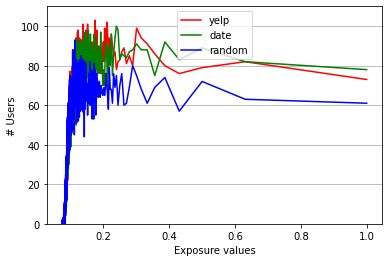

In [ ]:
################################################################################
#CALCOLA il grafico complessivo su tutti i ristoranti per un gruppo

def get_total_plots(all_yelp_exposures, all_date_exposures, all_rand_exposures,
                    title, destination):
  #width = 0.20
  y_min = 0
  y_max = 110

  #x = np.linspace(0, 1, 3000)
  x = [el['exposure'] for i, el in all_yelp_exposures[['exposure']]
       .drop_duplicates('exposure',keep='last')
       .sort_values('exposure')
       .reset_index(drop=True)
       .iterrows()]

  y1 = sum_users(x, all_yelp_exposures)
  y2 = sum_users(x, all_date_exposures)
  y3 = sum_users(x, all_rand_exposures)

  plt.plot(x,y1, color='red', label='yelp')
  plt.plot(x,y2, color='green', label='date')
  plt.plot(x,y3, color='blue', label='random')
  plt.legend(loc="upper center")
  plt.xlabel('Exposure values')
  plt.ylabel('# Users')
  #this_range = [str(int(id)) + ":" + "{:.{}f}".format(percent,1) + "%" for id, percent in zip(np.arange(min(x2), max(x2)+1, 1.0), percents)]
  #plt.xticks(np.arange(min(x2), max(x2)+1, 1.0),this_range)
  #plt.yticks(np.arange(y_min, y_max, 0.05))
  axes = plt.gca()
  axes.set_ylim([y_min,y_max])
  axes.yaxis.grid()

  #destination = set_file_destination(list_of_attributes, method, business_id)
  
  plt.show()
  #plt.savefig(title + '.png')
  #upload_file(title + '.png', destination)
  plt.close()


def sum_users(x, rank_exposures):
  res = []
  for i in x:
    user_num = len(rank_exposures[rank_exposures['exposure'] == i].values.tolist())
    res.append(user_num)
  return res


def crea_grafico(gruppo, method):
  all_yelp = pd.read_csv('all_yelp_' + method + '_' + gruppo + '.csv')
  all_date = pd.read_csv('all_date_' + method + '_' + gruppo + '.csv')
  all_rand = pd.read_csv('all_rand_' + method + '_' + gruppo + '.csv')
  get_total_plots(all_yelp, all_date, all_rand, 'all_'+gruppo+'_demgr_plot', '')


crea_grafico('fem', 'demgr')
crea_grafico('mas', 'demgr')
crea_grafico('unk', 'demgr')
crea_grafico('fem', 'disptr')
crea_grafico('mas', 'disptr')
crea_grafico('unk', 'disptr')
crea_grafico('fem', 'dispimp')
crea_grafico('mas', 'dispimp')
crea_grafico('unk', 'dispimp')

In [ ]:
## CHECK ALL WORKFLOW ##
# DOWNLOAD restaurants.txt FROM DRIVE
restaurants_dataset_id = '1BqMsph8flQMGmcE_WxYV0vSC_uqi-nge'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': restaurants_dataset_id})
download.GetContentFile('restaurants.txt')
with open('restaurants.txt') as f:
    content = f.readlines()
restaurants_id_list = [x.strip() for x in content] 

print(restaurants_id_list)


download = drive.CreateFile({'id': '1MIWS9uI9GKxsgAlzB0wXFBiutE025u2c'}) # id file gtree.csv
download.GetContentFile('gtree.csv')
gtree = pd.read_csv('gtree.csv')

index_restaurant = 20
i = index_restaurant
for id in restaurants_id_list[index_restaurant-1:]:
  print('inizio', id)
  print(i)
  esci = False
  folder = gtree.loc[gtree['business_id']==id, 'gfolder_#14'].tolist()[0]
  if not folder:
    print('La cartella nel gtree non esiste')
    break
  fileList = drive.ListFile({'q': "'" + folder + "' in parents and trashed=false"}).GetList()
  if len(fileList) != 34:
    print('I file non sono 34 ma:', len(fileList))
    break
  folderList = drive.ListFile({"q": "'" + folder + "' in parents and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
  if len(folderList) != 5:
    print('Mancano ' + str(len(folderList)) + ' assumptions')
    break
  for folder in folderList:
    new_folder_id = folder['id']
    new_file_list = drive.ListFile({'q': "'" + new_folder_id + "' in parents and trashed=false"}).GetList()
    if len(new_file_list) != 28:
      print('Mancano ' + str(28-len(new_file_list)) + ' file in ' + folder['title'])
      esci = True
  if esci:
    break
  print('fine', id)
  i += 1

['WbJ1LRQdOuYYlRLyTkuuxw', 'T2tEMLpTeSMxLKpxwFdS3g', 'ALwAlxItASeEs2vYAeLXHA', 'OVTZNSkSfbl3gVB9XQIJfw', 'Sovgwq-E-n6wLqNh3X_rXg', 'j5nPiTwWEFr-VsePew7Sjg', 'aiX_WP7NKPTdF9CfI-M-wg', 'e4NQLZynhSmvwl38hC4m-A', 'S-oLPRdhlyL5HAknBKTUcQ', 'VyVIneSU7XAWgMBllI6LnQ', 'pSQFynH1VxkfSmehRXlZWw', 'JzOp695tclcNCNMuBl7oxA', 'OgJ0KxwJcJ9R5bUK0ixCbg', '3l54GTr8-E3XPbIxnF_sAA', '9a3DrZvpYxVs3k_qwlCNSw', 'frCxZS7lPhEnQRJ3UY6m7A', 'yNPh5SO-7wr8HPpVCDPbXQ', '0FUtlsQrJI7LhqDPxLumEw', 'K-uQkfSUTwu5LIwPB4b_vg', 'L2p0vO3fsS2LC6hhQo3CzA', 'd10IxZPirVJlOSpdRZJczA', 'wUKzaS1MHg94RGM6z8u9mw', 'z6-reuC5BYf_Rth9gMBfgQ', 'aiX_WP7NKPTdF9CfI-M-wg', '3C5Z9homtzkWHouH2BHXYQ', 'C8D_GU9cDDjbOJfCaGXxDQ', 'Yl05MqCs9xRzrJFkGWLpgA', 'eS29S_06lvsDW04wVrIVxg', 'IsoLzudHC50oJLiEWpwV-w', '3N9U549Zse8UP-MwKZAjAQ', '_XN-GwzZwAyIqLKJsl2htg', 'r5PLDU-4mSbde5XekTXSCA', 'Iq7NqQD-sESu3vr9iEGuTA', 'u-SJ5QUwrNquL9VnXwl8cg', 'sJNcipFYElitBrtiJx0ezQ', '7m1Oa1VYV98UUuo_6i0EZg', 'e4NQLZynhSmvwl38hC4m-A', 'k1QpHAkzKTrFYfk6u--VgQ', '-6tvduBzjL